### Learning reaction types using different ML methods (RF, NB) and more local difference fingerprints (AP3, MG2, TT)

Goal: find the best/simplest/most appropriate ML model for our FPs

In [1]:
import _pickle as cPickle
import gzip
from collections import defaultdict
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import utilsFunctions

Choose some larger text size in the plots

In [2]:
dataDir = "../data/"

with open(dataDir+"reactionTypes_training_test_set_patent_data.pkl",'rb') as f:
    reaction_types = cPickle.load(f)
with open(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl",'rb') as f:
    names_rTypes = cPickle.load(f)
# names_rTypes = cPickle.load((dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl"))

# reaction_types = cPickle.load(file(dataDir+"reactionTypes_training_test_set_patent_data.pkl"))
# names_rTypes = cPickle.load(file(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl"))

Load the different FPs (AP3, MG2, TT)

In [3]:
infile = gzip.open(dataDir+"transformationFPs_test_set_patent_data.pkl.gz", 'rb')

lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,fp_AP3,fp_MG2,fp_TT = cPickle.load(infile)        
    except EOFError:
        break
    fps.append([idx,lbl,cls,fp_AP3,fp_MG2,fp_TT])
    idx+=1
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000


Split the FPs in training (20 %) and test data (80 %) per recation type (200, 800).
Build the "positive" version of the difference transformation fingerprints.

In [6]:
random.seed(0xd00f)
indices=list(range(len(fps))) ## python3 convention
# print(indices[1:10])
random.shuffle(indices)

nActive=200
fpsz=2048
#fpsz=4096
trainFps_fp_AP3=[]
trainFps_fp_MG2=[]
trainFps_fp_TT=[]
trainActs=[]
testFps_fp_AP3=[]
testFps_fp_MG2=[]
testFps_fp_TT=[]
testActs=[]

print('building fp collection')

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
#     print(actI)
    for x in actIds[:nActive]:
        trfp_AP3 = utilsFunctions.hashFP(fps[x][3],fpsz)
        trfp_AP3 = utilsFunctions.removeNegativeCountsFP(trfp_AP3)
        trainFps_fp_AP3 += [utilsFunctions.hashedFPToNP(trfp_AP3,fpsz*2)]
        trfp_MG2 = utilsFunctions.hashFP(fps[x][4],fpsz)
        trfp_MG2 = utilsFunctions.removeNegativeCountsFP(trfp_MG2)
        trainFps_fp_MG2 += [utilsFunctions.hashedFPToNP(trfp_MG2,fpsz*2)]
        trfp_TT = utilsFunctions.hashFP(fps[x][5],fpsz)
        trfp_TT = utilsFunctions.removeNegativeCountsFP(trfp_TT)
        trainFps_fp_TT += [utilsFunctions.hashedFPToNP(trfp_TT,fpsz*2)]
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        tefp_AP3 = utilsFunctions.hashFP(fps[x][3],fpsz)
        tefp_AP3 = utilsFunctions.removeNegativeCountsFP(tefp_AP3)
        testFps_fp_AP3 += [utilsFunctions.hashedFPToNP(tefp_AP3,fpsz*2)]
        tefp_MG2 = utilsFunctions.hashFP(fps[x][4],fpsz)
        tefp_MG2 = utilsFunctions.removeNegativeCountsFP(tefp_MG2)
        testFps_fp_MG2 += [utilsFunctions.hashedFPToNP(tefp_MG2,fpsz*2)]
        tefp_TT = utilsFunctions.hashFP(fps[x][5],fpsz)
        tefp_TT = utilsFunctions.removeNegativeCountsFP(tefp_TT)
        testFps_fp_TT += [utilsFunctions.hashedFPToNP(tefp_TT,fpsz*2)]
    testActs += [i]*nTest

building fp collection


Build the multinomial NB classifer with the "positive" version of the FPs

In [7]:
print('training models')
clf_AP3 = MultinomialNB(alpha=0.0001)
res_NB_AP3 = clf_AP3.fit(trainFps_fp_AP3, trainActs)
clf_MG2 = MultinomialNB(alpha=0.0001)
res_NB_MG2 = clf_MG2.fit(trainFps_fp_MG2, trainActs)
clf_TT = MultinomialNB(alpha=0.0001)
res_NB_TT = clf_TT.fit(trainFps_fp_TT, trainActs)

training models


Evaluate the classifier

In [8]:
cmat_NB_fp_AP3 = utilsFunctions.evaluateModel(res_NB_AP3, testFps_fp_AP3, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9862  0.9348  0.9599     1.2.1 Aldehyde reductive amination
 1  0.9762  0.9812  0.9787     1.2.4 Eschweiler-Clarke methylation
 2  0.9650  0.9772  0.9711     1.2.5 Ketone reductive amination
 3  0.9663  0.9579  0.9620     1.3.6 Bromo N-arylation
 4  0.9337  0.9384  0.9361     1.3.7 Chloro N-arylation
 5  0.9575  0.9935  0.9752     1.3.8 Fluoro N-arylation
 6  0.9563  0.9696  0.9629     1.6.2 Bromo N-alkylation
 7  0.9175  0.9118  0.9146     1.6.4 Chloro N-alkylation
 8  0.8925  0.8380  0.8644     1.6.8 Iodo N-alkylation
 9  0.9363  0.9566  0.9463     1.7.4 Hydroxy to methoxy
10  0.9688  0.6122  0.7502     1.7.6 Methyl esterification
11  0.9075  0.9590  0.9326     1.7.7 Mitsunobu aryl ether synthesis
12  0.9600  0.9540  0.9570     1.7.9 Williamson ether synthesis
13  0.9912  0.9718  0.9814     1.8.5 Thioether synthesis
14  0.8075  0.9073  0.8545    10.1.1 Bromination
15  0.9613  0.9333  0.9470    10.1.2 Chlorination
16  0.9682  0.8530

In [9]:
cmat_NB_fp_MG2 = utilsFunctions.evaluateModel(res_NB_MG2, testFps_fp_MG2, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9325  0.8735  0.9021     1.2.1 Aldehyde reductive amination
 1  0.8588  0.8179  0.8378     1.2.4 Eschweiler-Clarke methylation
 2  0.9275  0.9828  0.9543     1.2.5 Ketone reductive amination
 3  0.9087  0.8328  0.8691     1.3.6 Bromo N-arylation
 4  0.8612  0.9236  0.8913     1.3.7 Chloro N-arylation
 5  0.8975  0.9625  0.9288     1.3.8 Fluoro N-arylation
 6  0.8313  0.8418  0.8365     1.6.2 Bromo N-alkylation
 7  0.8163  0.7215  0.7660     1.6.4 Chloro N-alkylation
 8  0.7113  0.6914  0.7012     1.6.8 Iodo N-alkylation
 9  0.8825  0.9265  0.9040     1.7.4 Hydroxy to methoxy
10  0.7588  0.7664  0.7626     1.7.6 Methyl esterification
11  0.7550  0.8531  0.8011     1.7.7 Mitsunobu aryl ether synthesis
12  0.8538  0.8370  0.8453     1.7.9 Williamson ether synthesis
13  0.9775  0.9607  0.9690     1.8.5 Thioether synthesis
14  0.8237  0.7306  0.7744    10.1.1 Bromination
15  0.7812  0.7242  0.7517    10.1.2 Chlorination
16  0.9007  0.9645

In [10]:
cmat_NB_fp_TT = utilsFunctions.evaluateModel(res_NB_TT, testFps_fp_TT, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9200  0.7914  0.8509     1.2.1 Aldehyde reductive amination
 1  0.8650  0.7105  0.7802     1.2.4 Eschweiler-Clarke methylation
 2  0.9425  0.9150  0.9286     1.2.5 Ketone reductive amination
 3  0.8700  0.8375  0.8535     1.3.6 Bromo N-arylation
 4  0.8988  0.9021  0.9004     1.3.7 Chloro N-arylation
 5  0.9038  0.9187  0.9112     1.3.8 Fluoro N-arylation
 6  0.6538  0.7771  0.7101     1.6.2 Bromo N-alkylation
 7  0.7375  0.7919  0.7638     1.6.4 Chloro N-alkylation
 8  0.6538  0.6819  0.6675     1.6.8 Iodo N-alkylation
 9  0.8588  0.9542  0.9039     1.7.4 Hydroxy to methoxy
10  0.8488  0.6252  0.7200     1.7.6 Methyl esterification
11  0.7362  0.8426  0.7859     1.7.7 Mitsunobu aryl ether synthesis
12  0.8475  0.7644  0.8038     1.7.9 Williamson ether synthesis
13  0.9738  0.9318  0.9523     1.8.5 Thioether synthesis
14  0.7612  0.7828  0.7719    10.1.1 Bromination
15  0.8025  0.7829  0.7926    10.1.2 Chlorination
16  0.9377  0.8489

Draw the confusion matrices

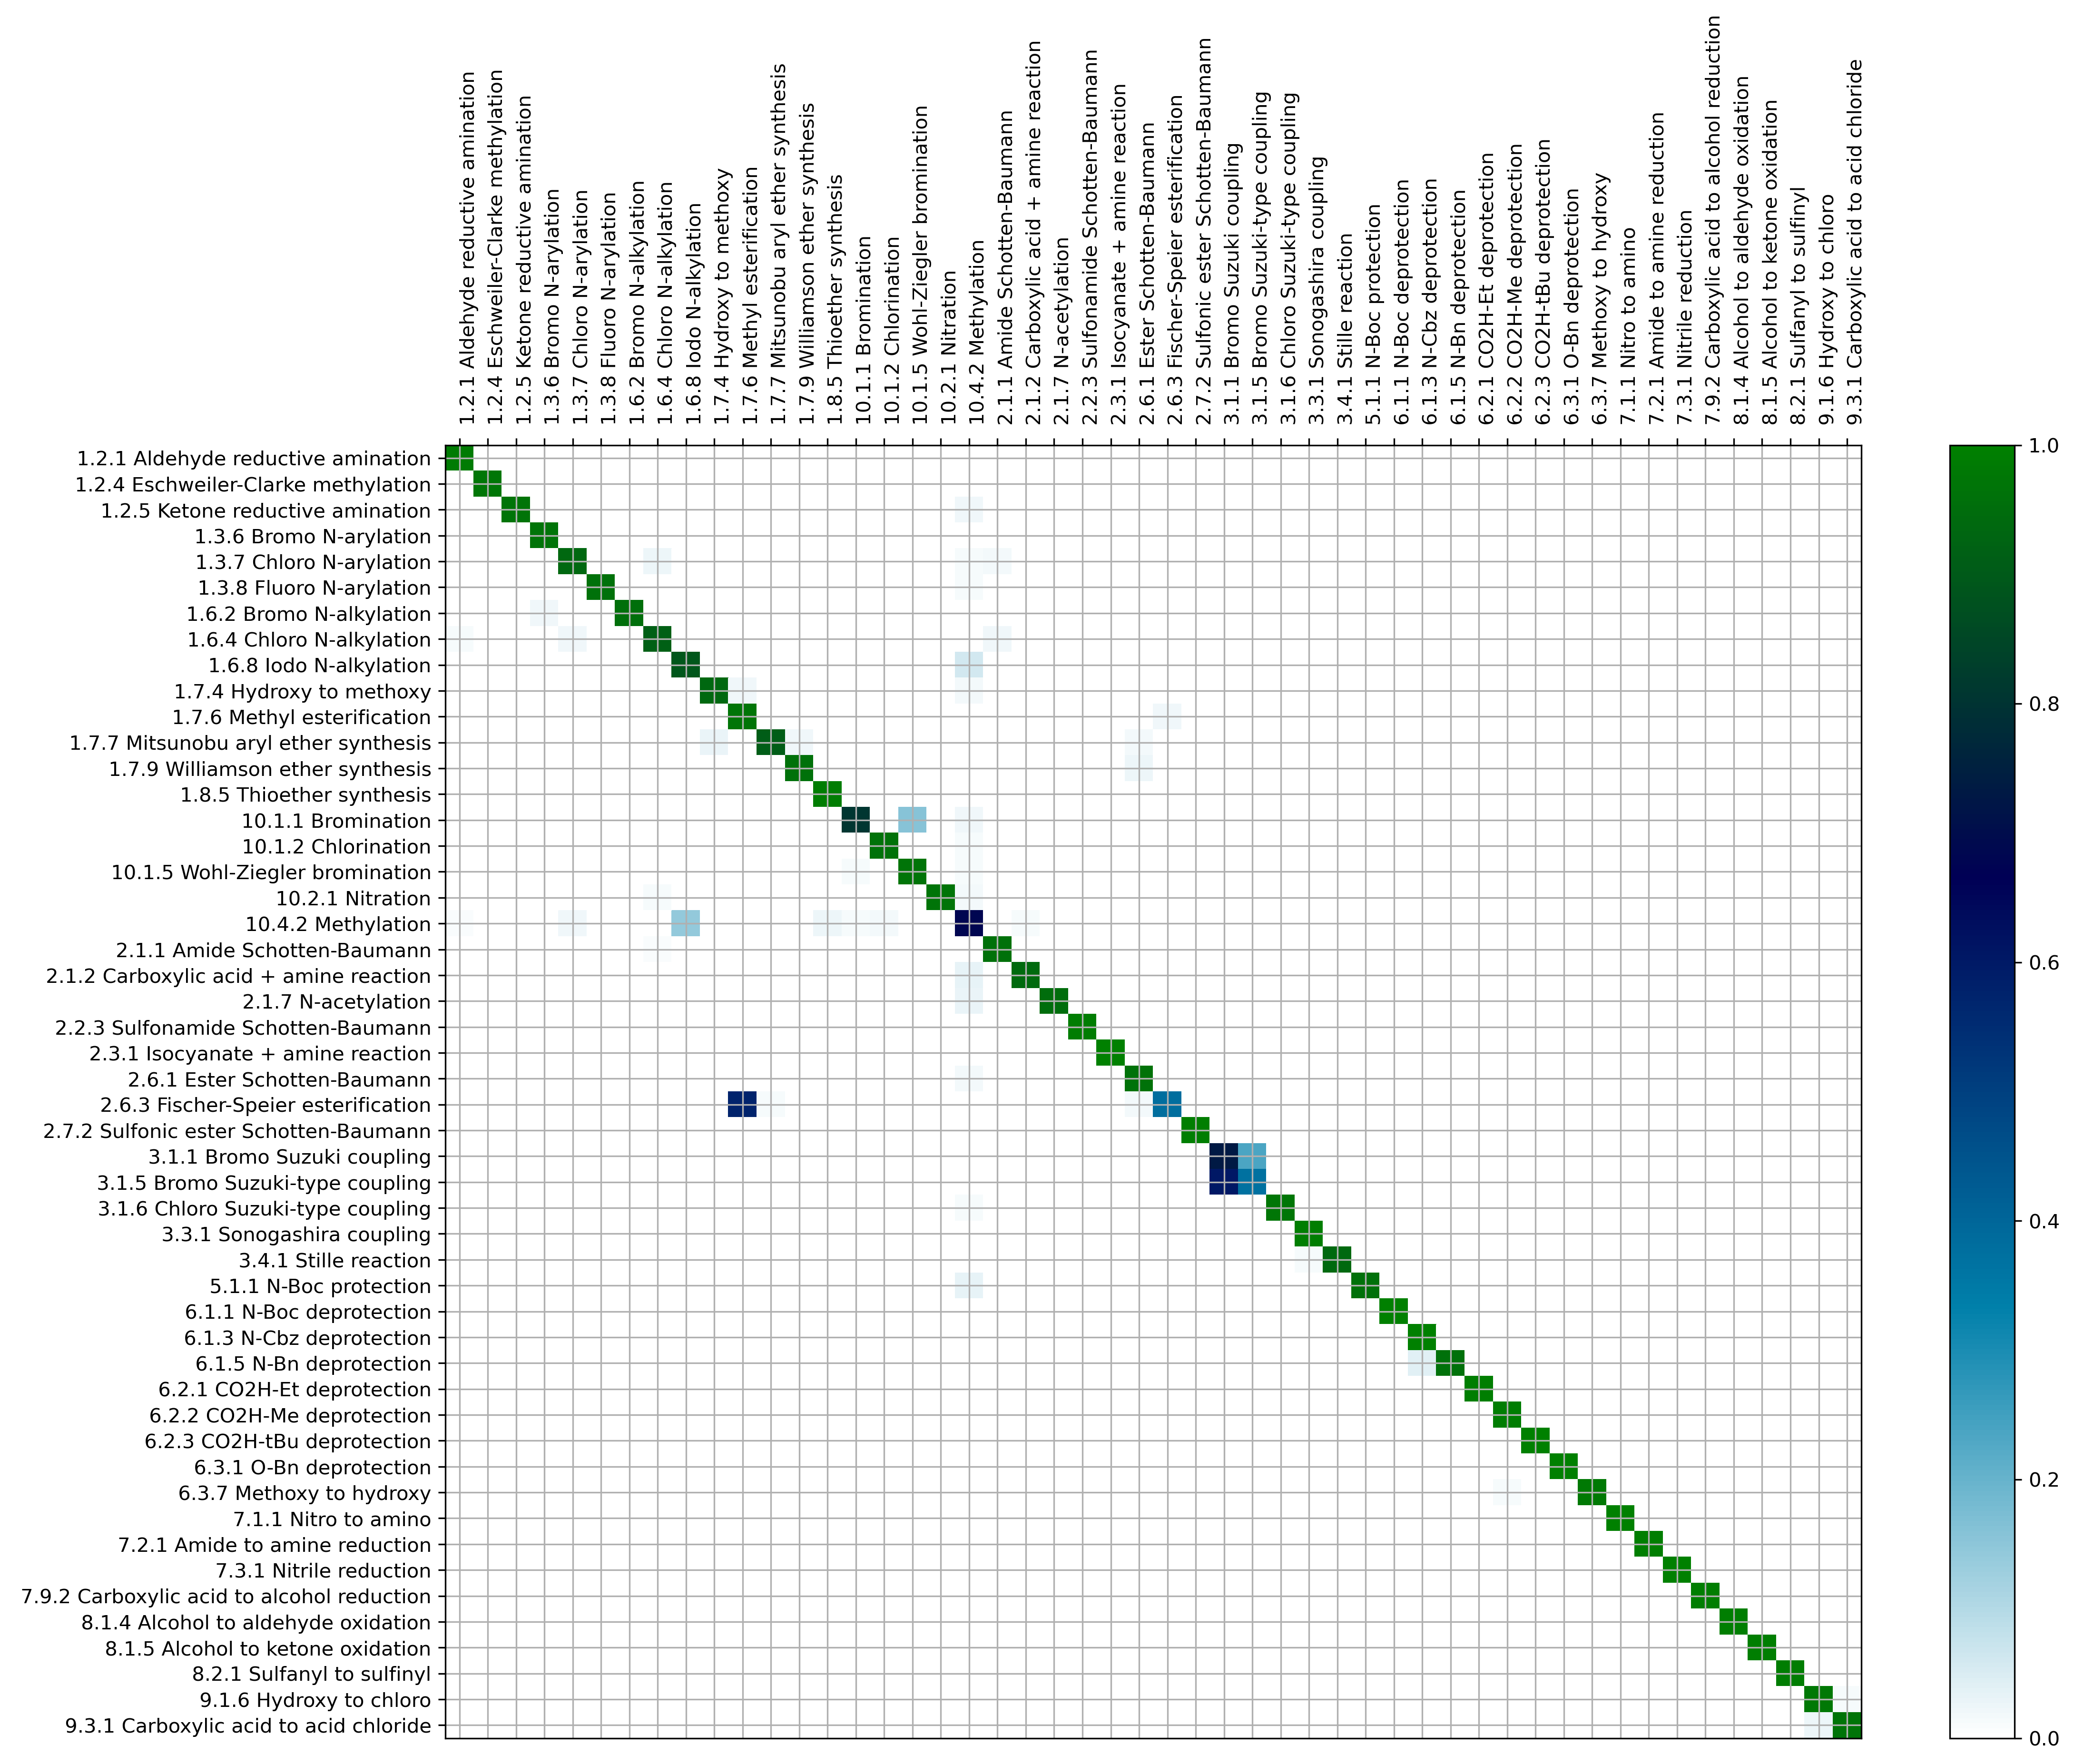

In [11]:
utilsFunctions.labelled_cmat(cmat_NB_fp_AP3,rtypes,figsize=(16,12), labelExtras=names_rTypes)

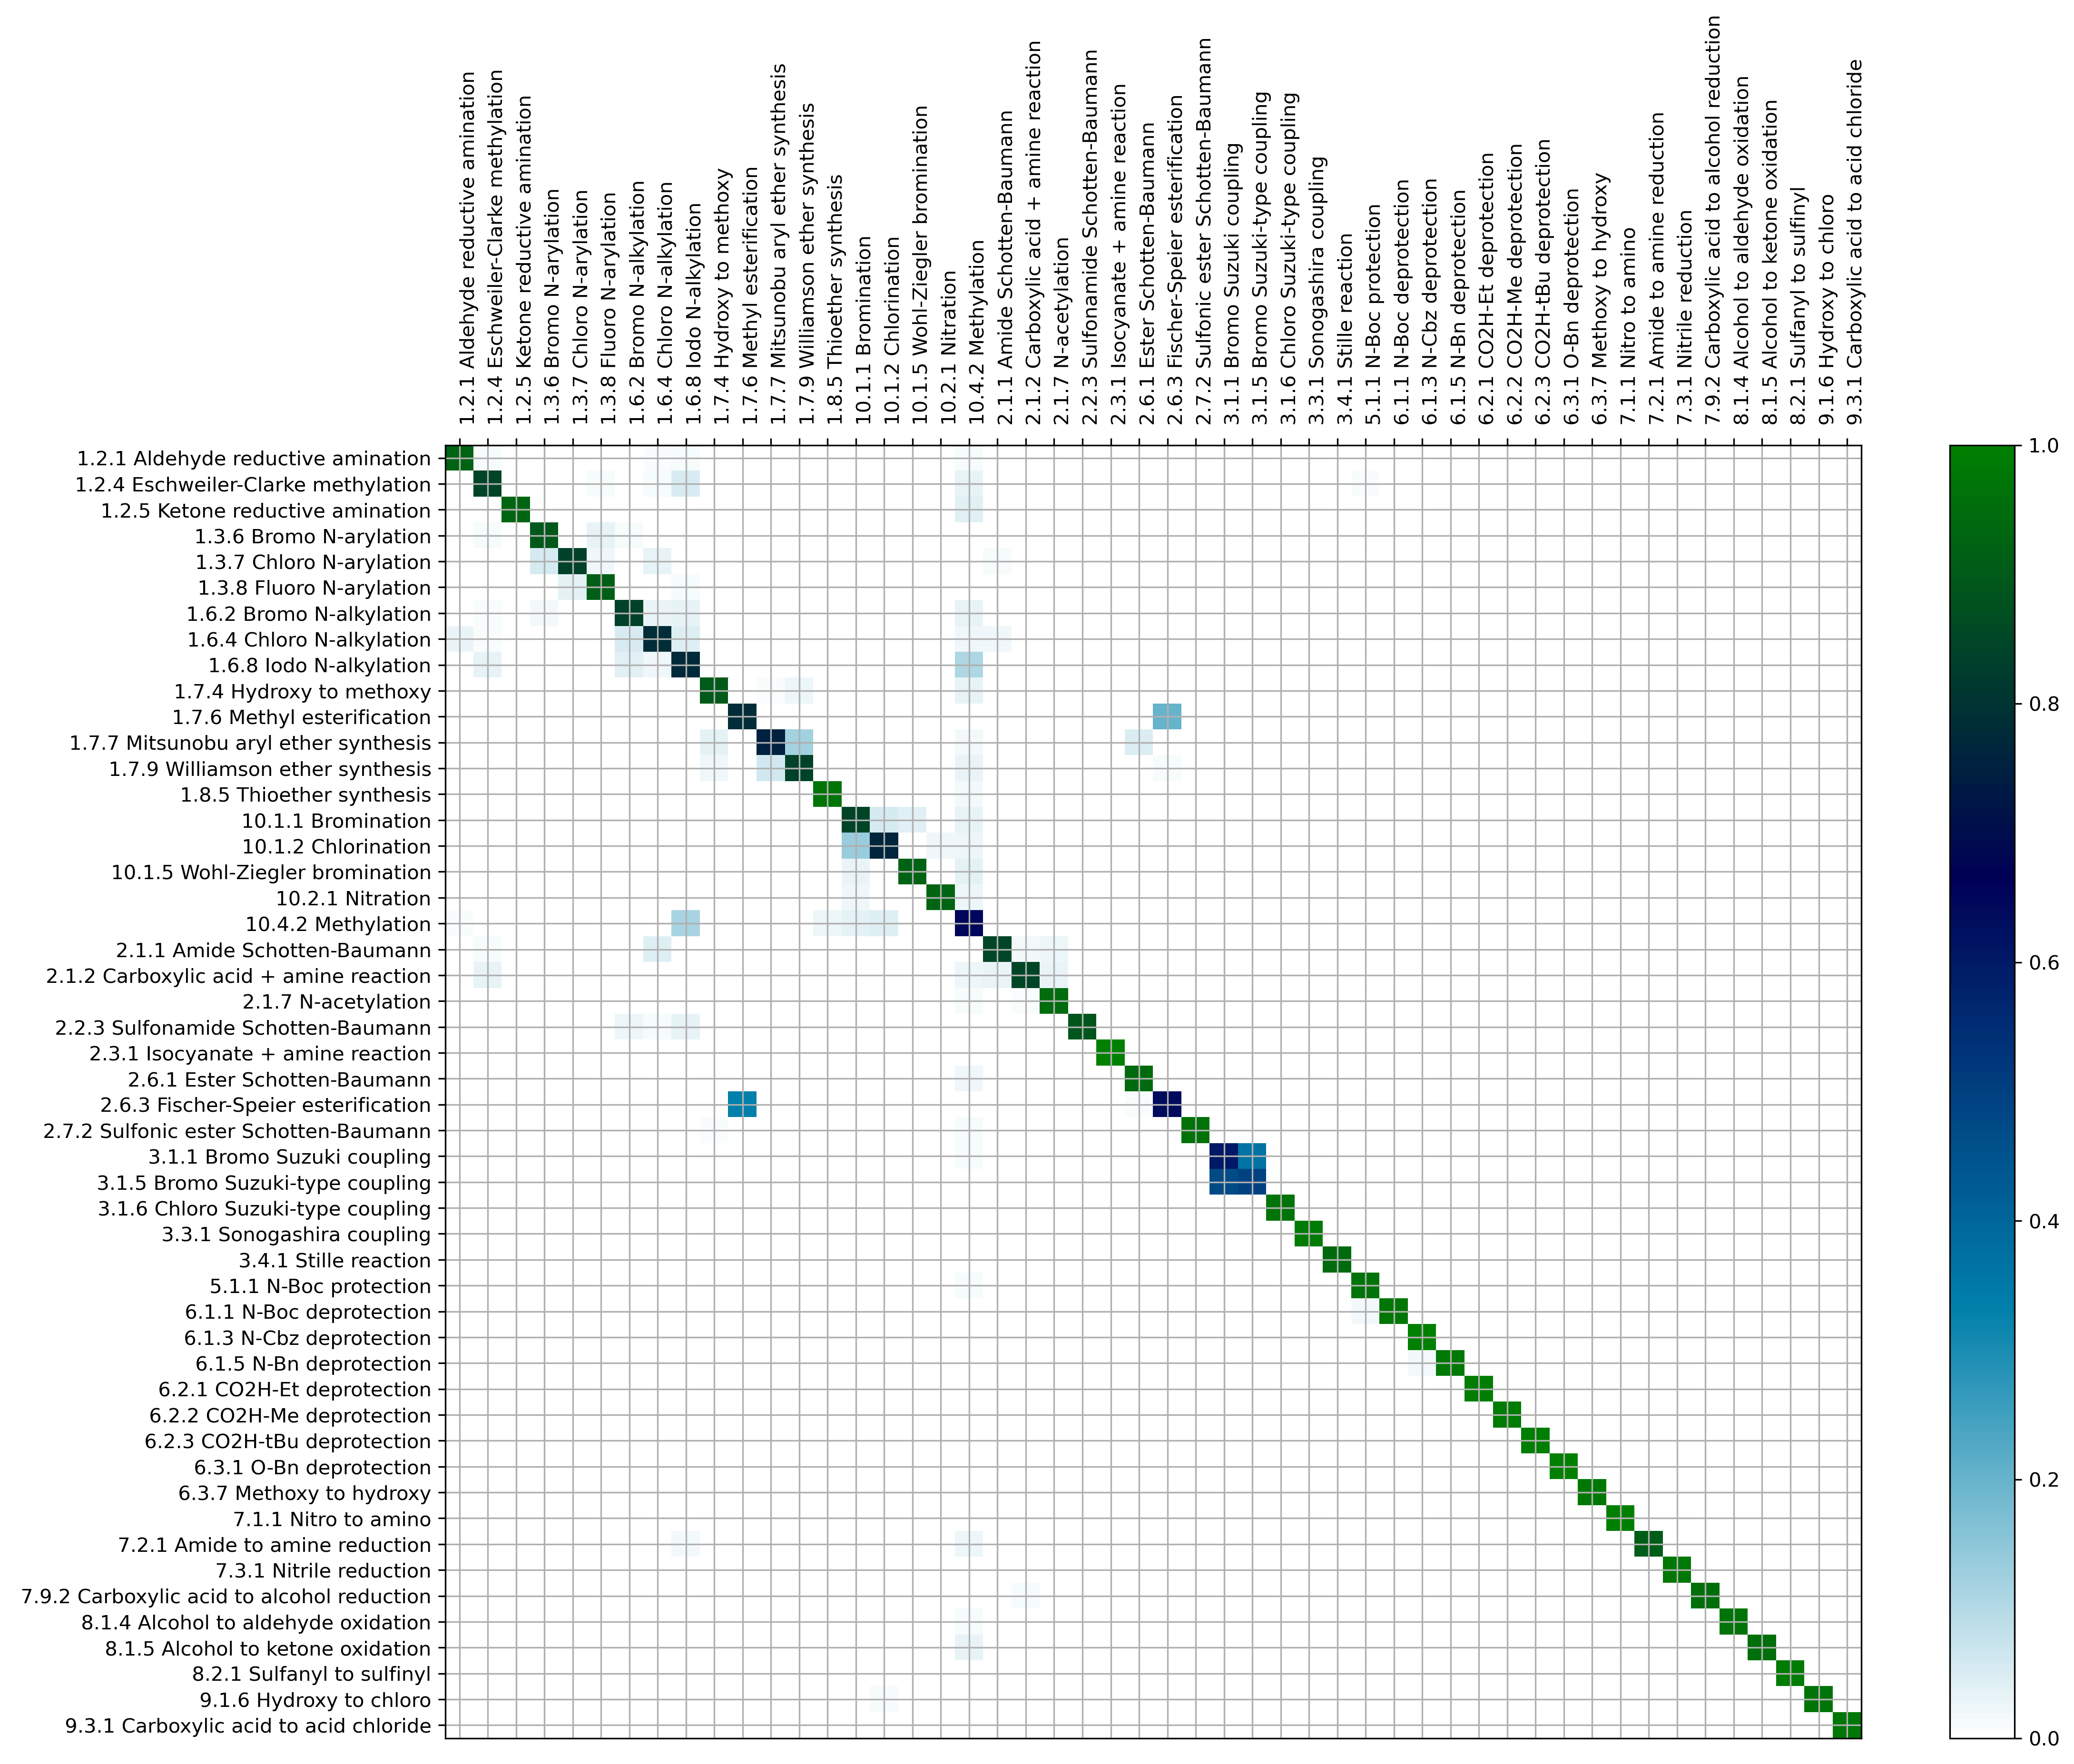

In [28]:
utilsFunctions.labelled_cmat(cmat_NB_fp_MG2,rtypes,figsize=(16,12), labelExtras=names_rTypes)

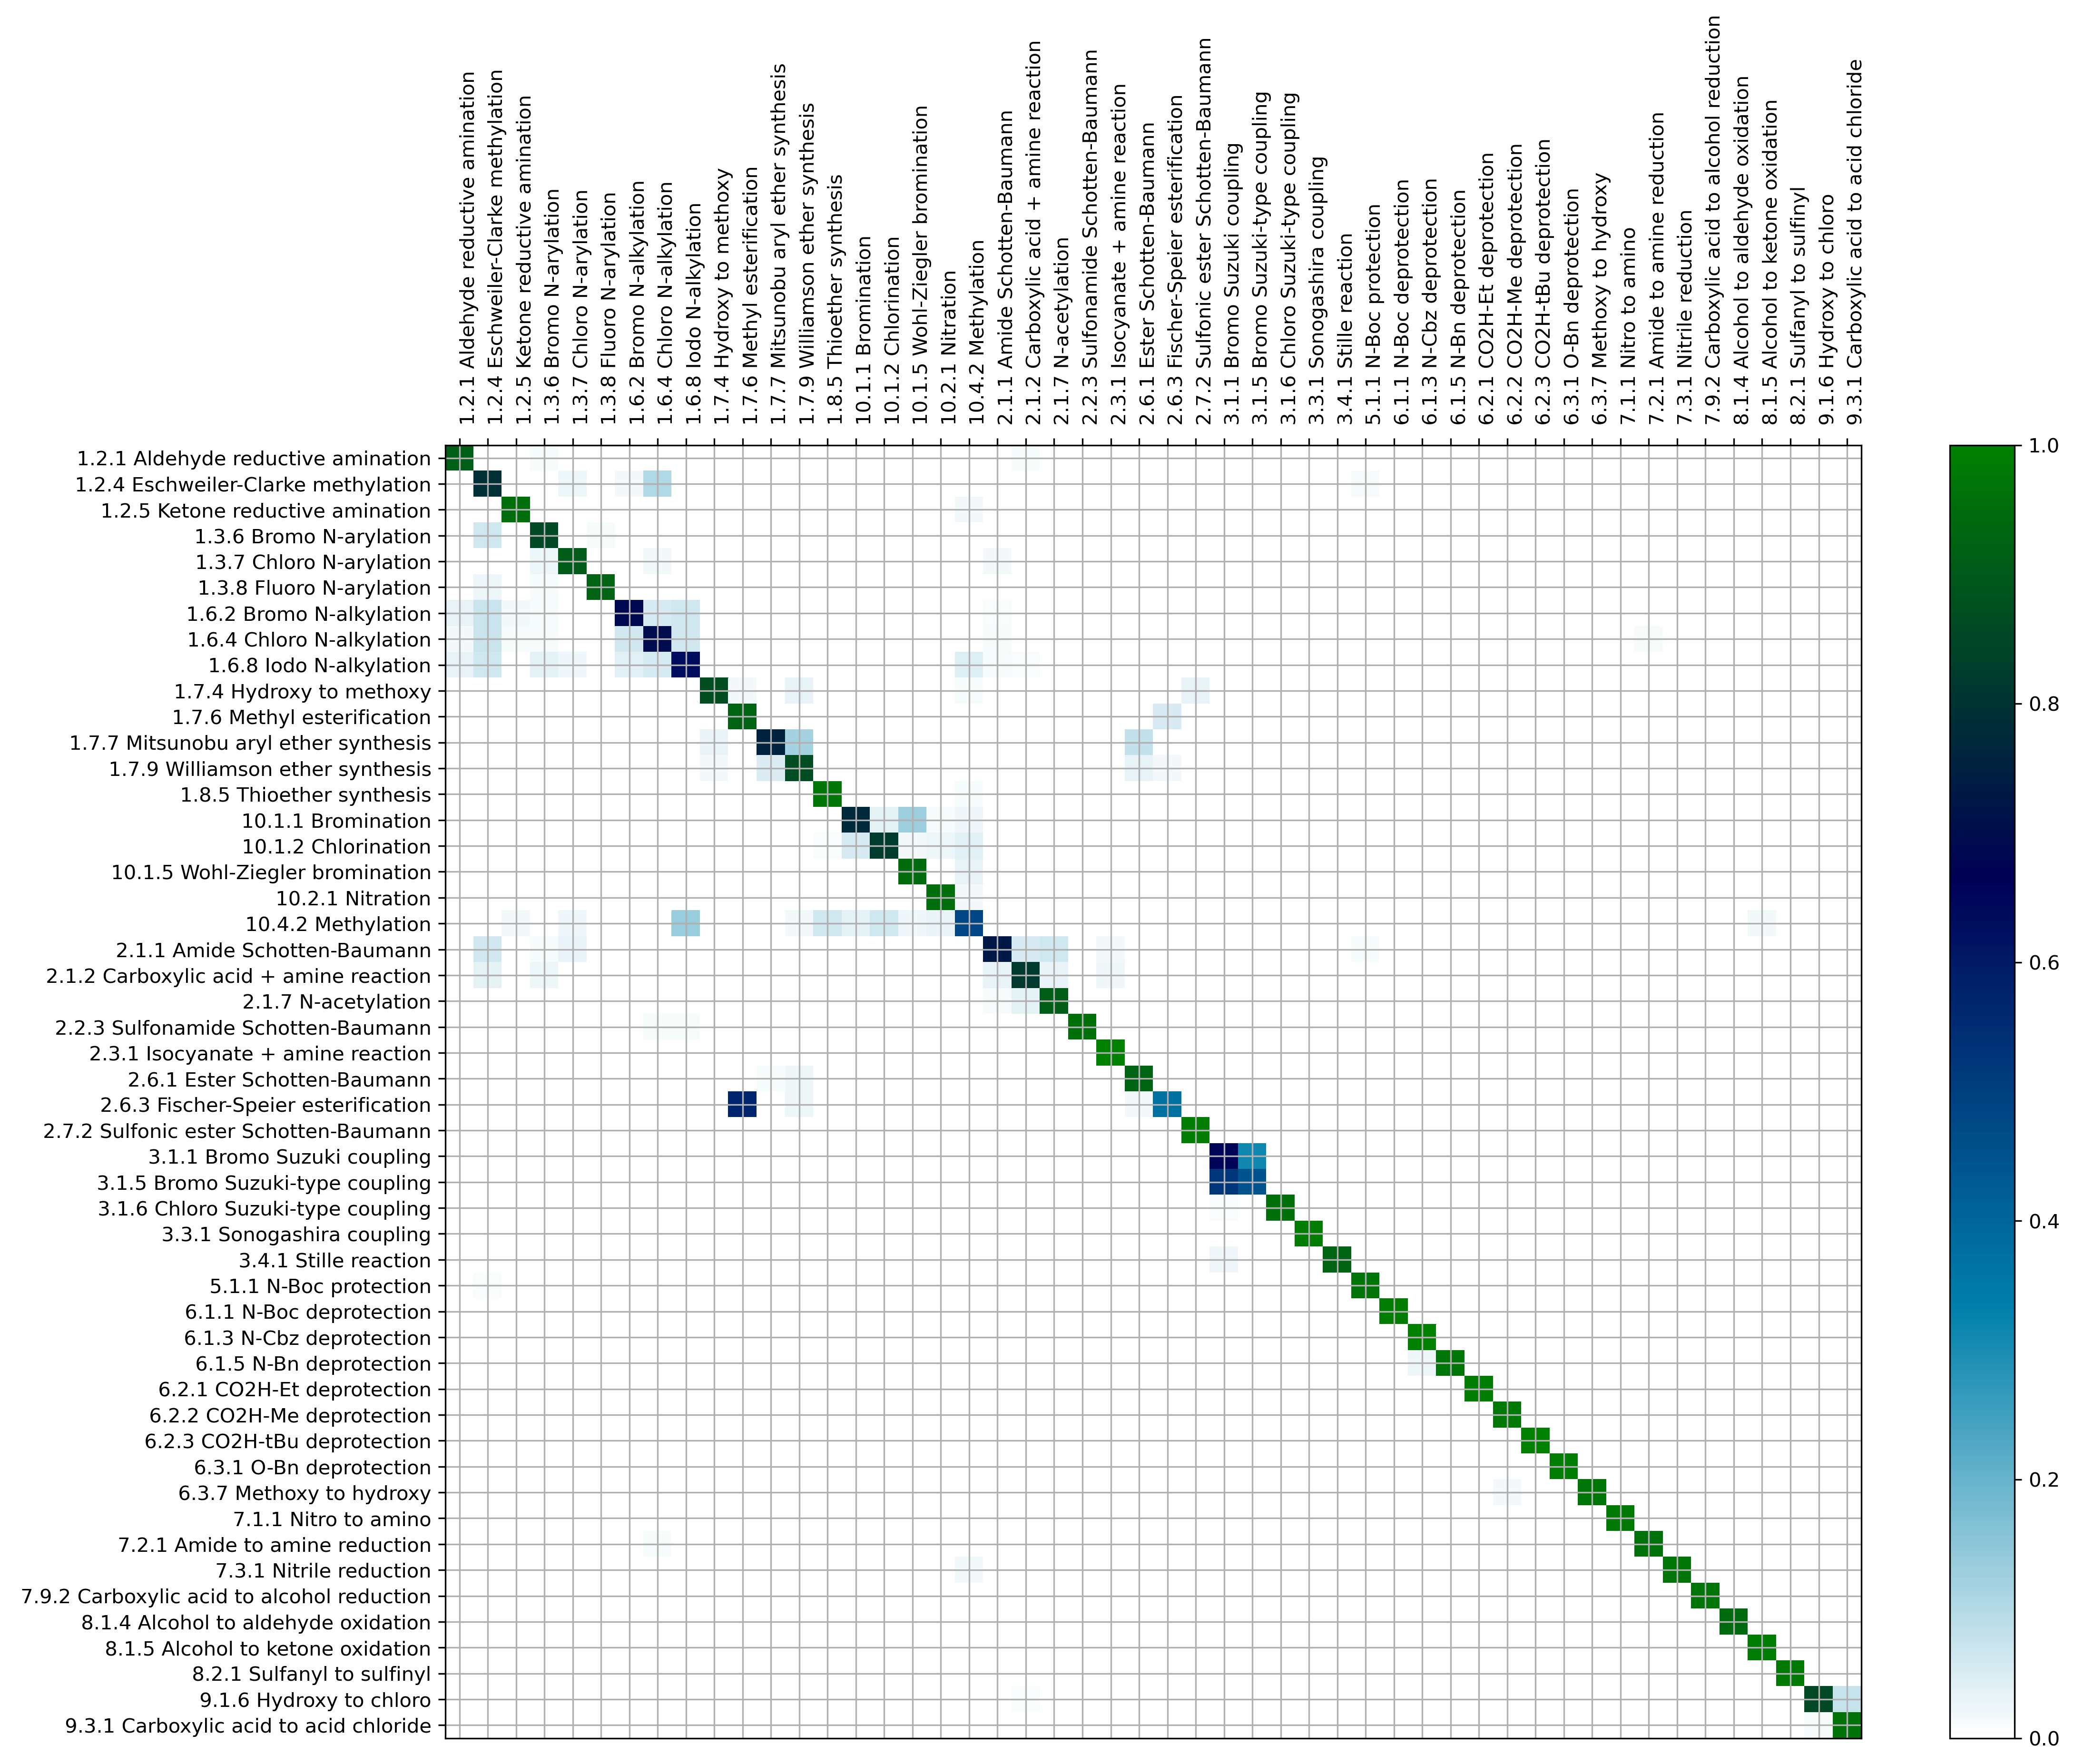

In [29]:
utilsFunctions.labelled_cmat(cmat_NB_fp_TT,rtypes,figsize=(16,12), labelExtras=names_rTypes)

#### Test the "positive" version of the FPs with RF classifiers (max tree depth = 25)

In [12]:
print('training models')
rf_cls_AP3 = RandomForestClassifier(n_estimators=200, max_depth=25,random_state=23,n_jobs=1)
result_rf_fp_AP3 = rf_cls_AP3.fit(trainFps_fp_AP3,trainActs)
rf_cls_MG2 = RandomForestClassifier(n_estimators=200, max_depth=25,random_state=23,n_jobs=1)
result_rf_fp_MG2 = rf_cls_MG2.fit(trainFps_fp_MG2,trainActs)
rf_cls_TT = RandomForestClassifier(n_estimators=200, max_depth=25,random_state=23,n_jobs=1)
result_rf_fp_TT = rf_cls_TT.fit(trainFps_fp_TT,trainActs)

training models


Evalutate the RF classifier using our test data

In [13]:
cmat_fp_AP3 = utilsFunctions.evaluateModel(result_rf_fp_AP3, testFps_fp_AP3, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9850  0.9765  0.9807     1.2.1 Aldehyde reductive amination
 1  0.9925  0.9352  0.9630     1.2.4 Eschweiler-Clarke methylation
 2  0.9850  0.9838  0.9844     1.2.5 Ketone reductive amination
 3  0.9775  0.9222  0.9490     1.3.6 Bromo N-arylation
 4  0.9762  0.9444  0.9600     1.3.7 Chloro N-arylation
 5  0.9912  0.9742  0.9827     1.3.8 Fluoro N-arylation
 6  0.9525  0.9682  0.9603     1.6.2 Bromo N-alkylation
 7  0.9375  0.9804  0.9585     1.6.4 Chloro N-alkylation
 8  0.9175  0.8697  0.8929     1.6.8 Iodo N-alkylation
 9  0.9750  0.9264  0.9501     1.7.4 Hydroxy to methoxy
10  0.7900  0.7930  0.7915     1.7.6 Methyl esterification
11  0.9363  0.9740  0.9547     1.7.7 Mitsunobu aryl ether synthesis
12  0.9350  0.9740  0.9541     1.7.9 Williamson ether synthesis
13  0.9925  0.9671  0.9796     1.8.5 Thioether synthesis
14  0.9175  0.9787  0.9471    10.1.1 Bromination
15  0.9712  0.9604  0.9658    10.1.2 Chlorination
16  0.9907  0.9362

In [14]:
cmat_fp_MG2 = utilsFunctions.evaluateModel(result_rf_fp_MG2, testFps_fp_MG2, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9850  0.9552  0.9698     1.2.1 Aldehyde reductive amination
 1  0.9187  0.8898  0.9041     1.2.4 Eschweiler-Clarke methylation
 2  0.9738  0.9886  0.9811     1.2.5 Ketone reductive amination
 3  0.9800  0.8909  0.9333     1.3.6 Bromo N-arylation
 4  0.9825  0.9335  0.9574     1.3.7 Chloro N-arylation
 5  0.9900  0.9694  0.9796     1.3.8 Fluoro N-arylation
 6  0.9337  0.9829  0.9577     1.6.2 Bromo N-alkylation
 7  0.8675  0.9639  0.9132     1.6.4 Chloro N-alkylation
 8  0.9150  0.8522  0.8825     1.6.8 Iodo N-alkylation
 9  0.9475  0.9056  0.9261     1.7.4 Hydroxy to methoxy
10  0.8087  0.7603  0.7838     1.7.6 Methyl esterification
11  0.9275  0.9763  0.9513     1.7.7 Mitsunobu aryl ether synthesis
12  0.9137  0.9721  0.9420     1.7.9 Williamson ether synthesis
13  0.9938  0.9555  0.9743     1.8.5 Thioether synthesis
14  0.9038  0.9770  0.9390    10.1.1 Bromination
15  0.9525  0.9315  0.9419    10.1.2 Chlorination
16  0.9894  0.9154

In [15]:
cmat_fp_TT = utilsFunctions.evaluateModel(result_rf_fp_TT, testFps_fp_TT, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.7963  0.8550  0.8246     1.2.1 Aldehyde reductive amination
 1  0.9163  0.7472  0.8231     1.2.4 Eschweiler-Clarke methylation
 2  0.8900  0.7955  0.8401     1.2.5 Ketone reductive amination
 3  0.8912  0.8488  0.8695     1.3.6 Bromo N-arylation
 4  0.9400  0.8095  0.8699     1.3.7 Chloro N-arylation
 5  0.9712  0.9056  0.9373     1.3.8 Fluoro N-arylation
 6  0.6075  0.6480  0.6271     1.6.2 Bromo N-alkylation
 7  0.5337  0.8356  0.6514     1.6.4 Chloro N-alkylation
 8  0.5763  0.5684  0.5723     1.6.8 Iodo N-alkylation
 9  0.7225  0.9146  0.8073     1.7.4 Hydroxy to methoxy
10  0.9712  0.6123  0.7511     1.7.6 Methyl esterification
11  0.7750  0.7673  0.7711     1.7.7 Mitsunobu aryl ether synthesis
12  0.5825  0.8759  0.6997     1.7.9 Williamson ether synthesis
13  0.8750  0.9272  0.9003     1.8.5 Thioether synthesis
14  0.8237  0.8310  0.8274    10.1.1 Bromination
15  0.7350  0.9102  0.8133    10.1.2 Chlorination
16  0.9139  0.9020

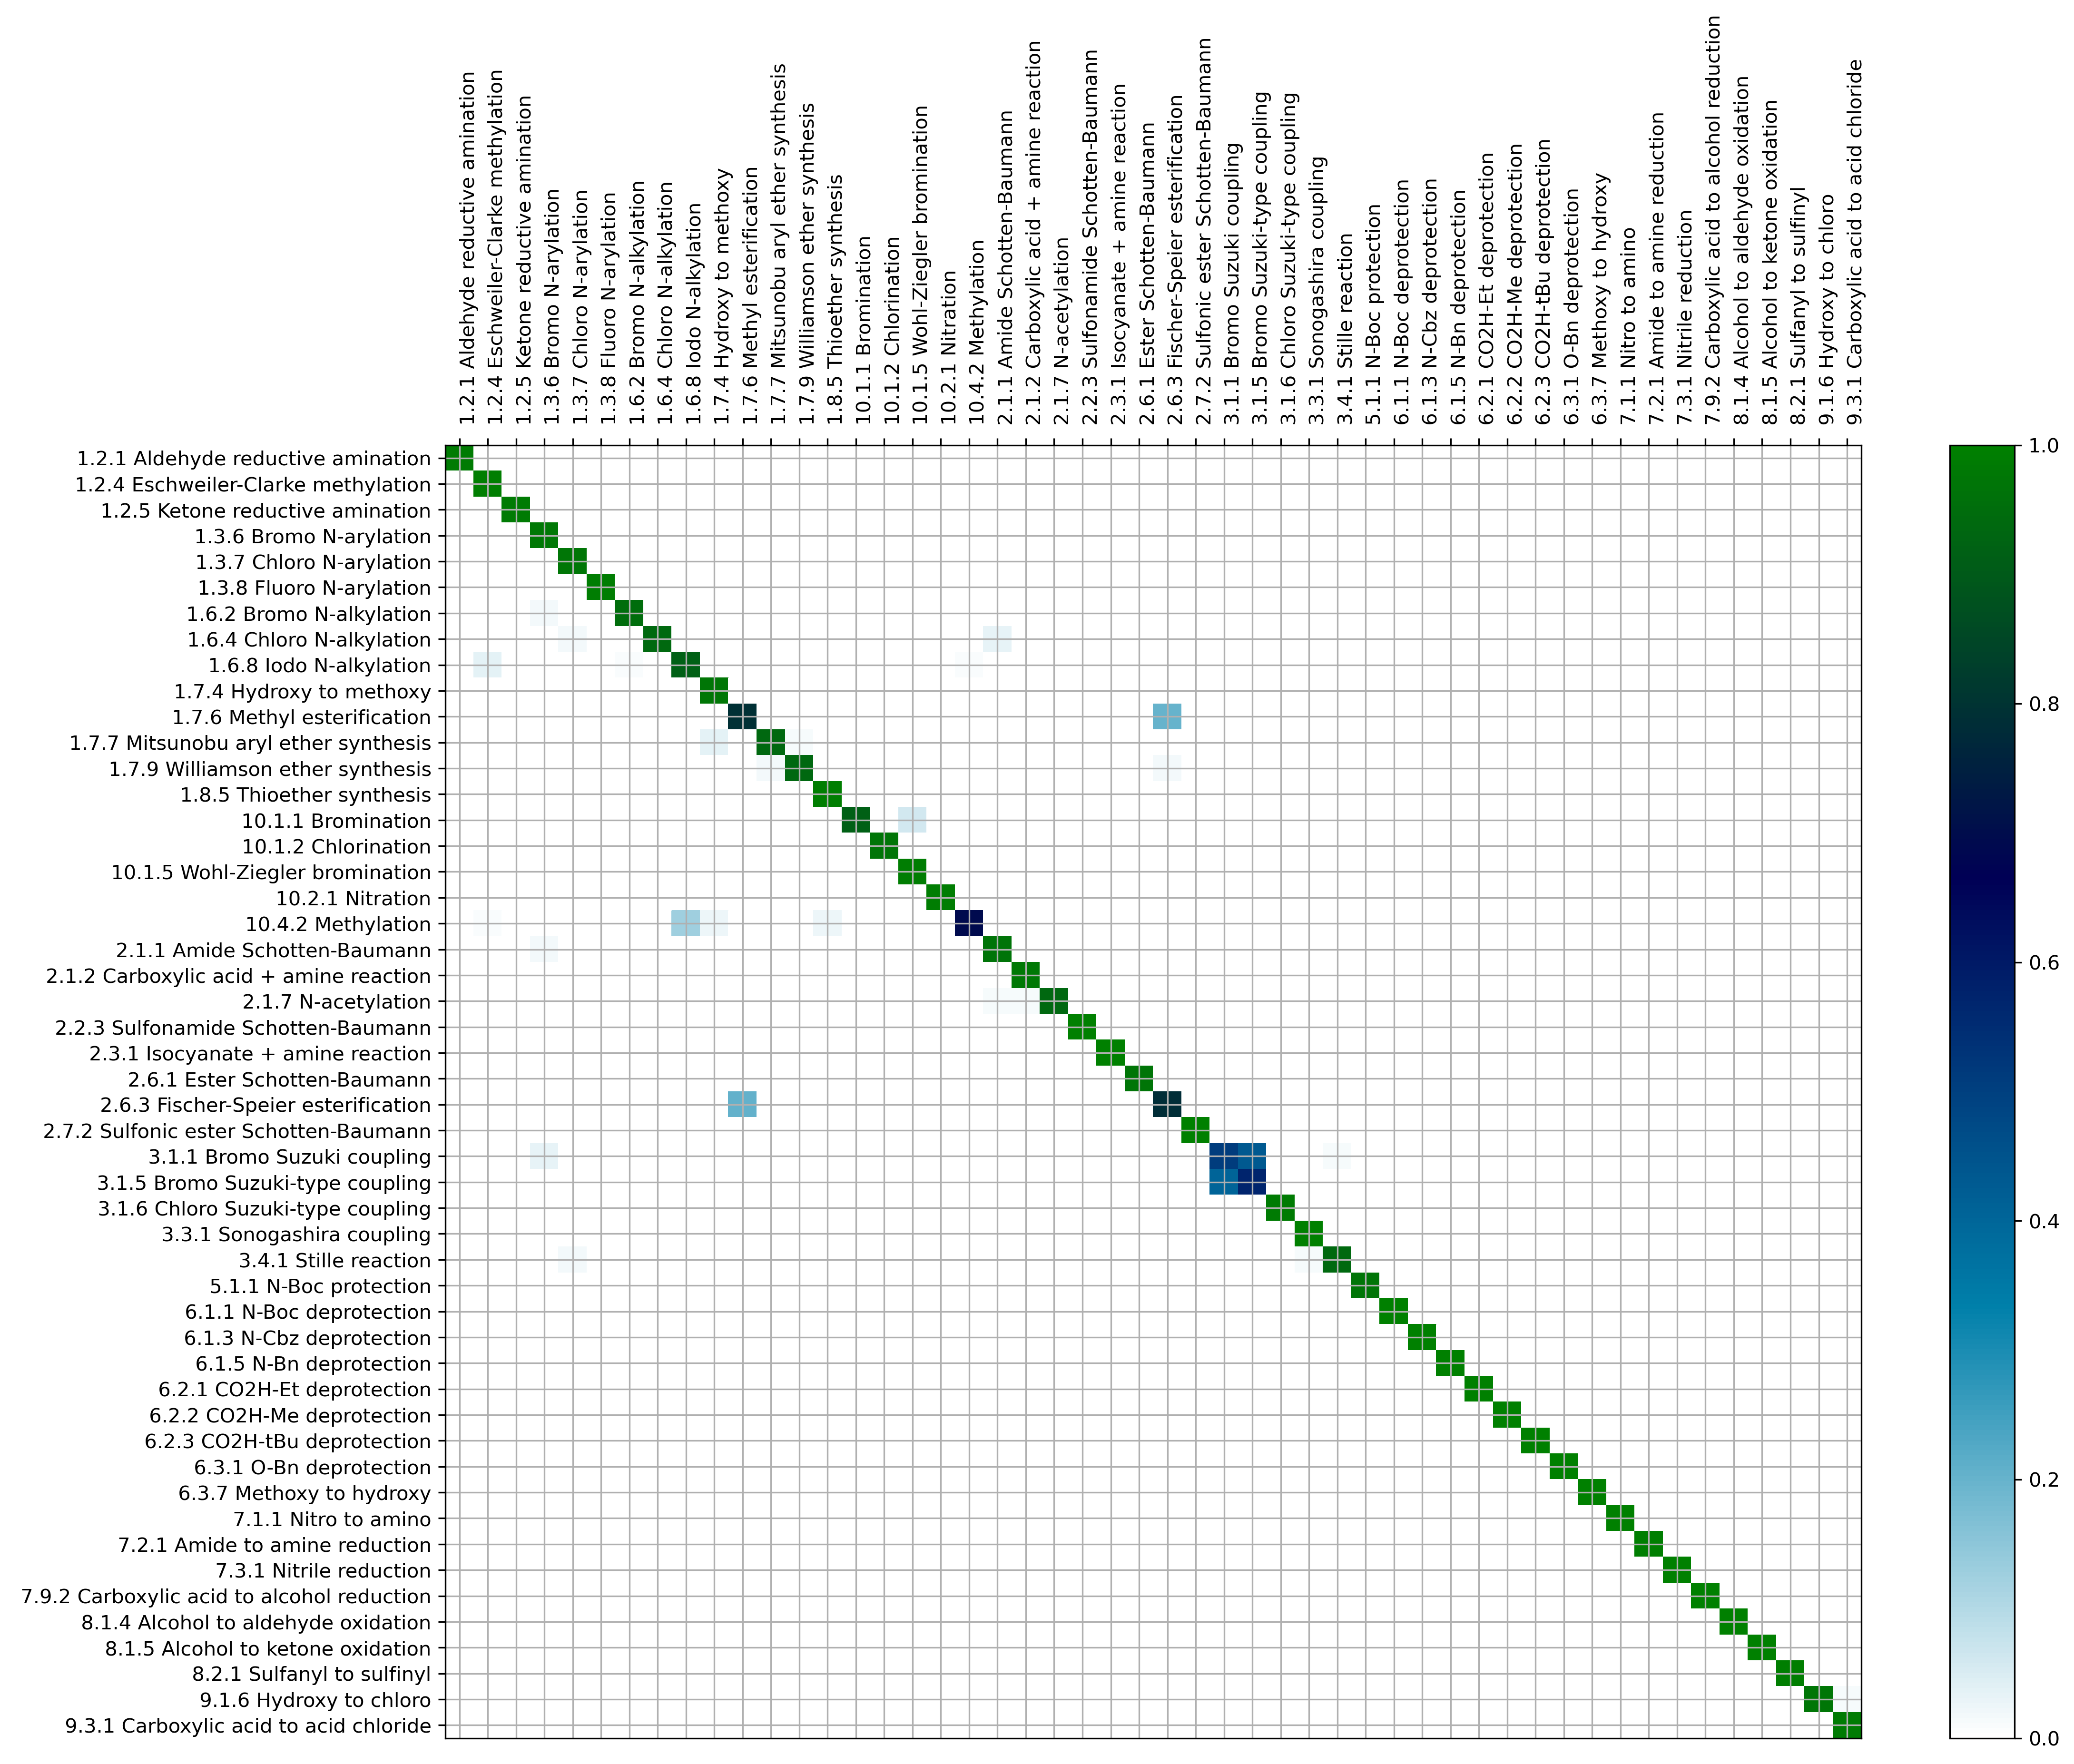

In [16]:
utilsFunctions.labelled_cmat(cmat_fp_AP3,rtypes,figsize=(16,12), labelExtras=names_rTypes)

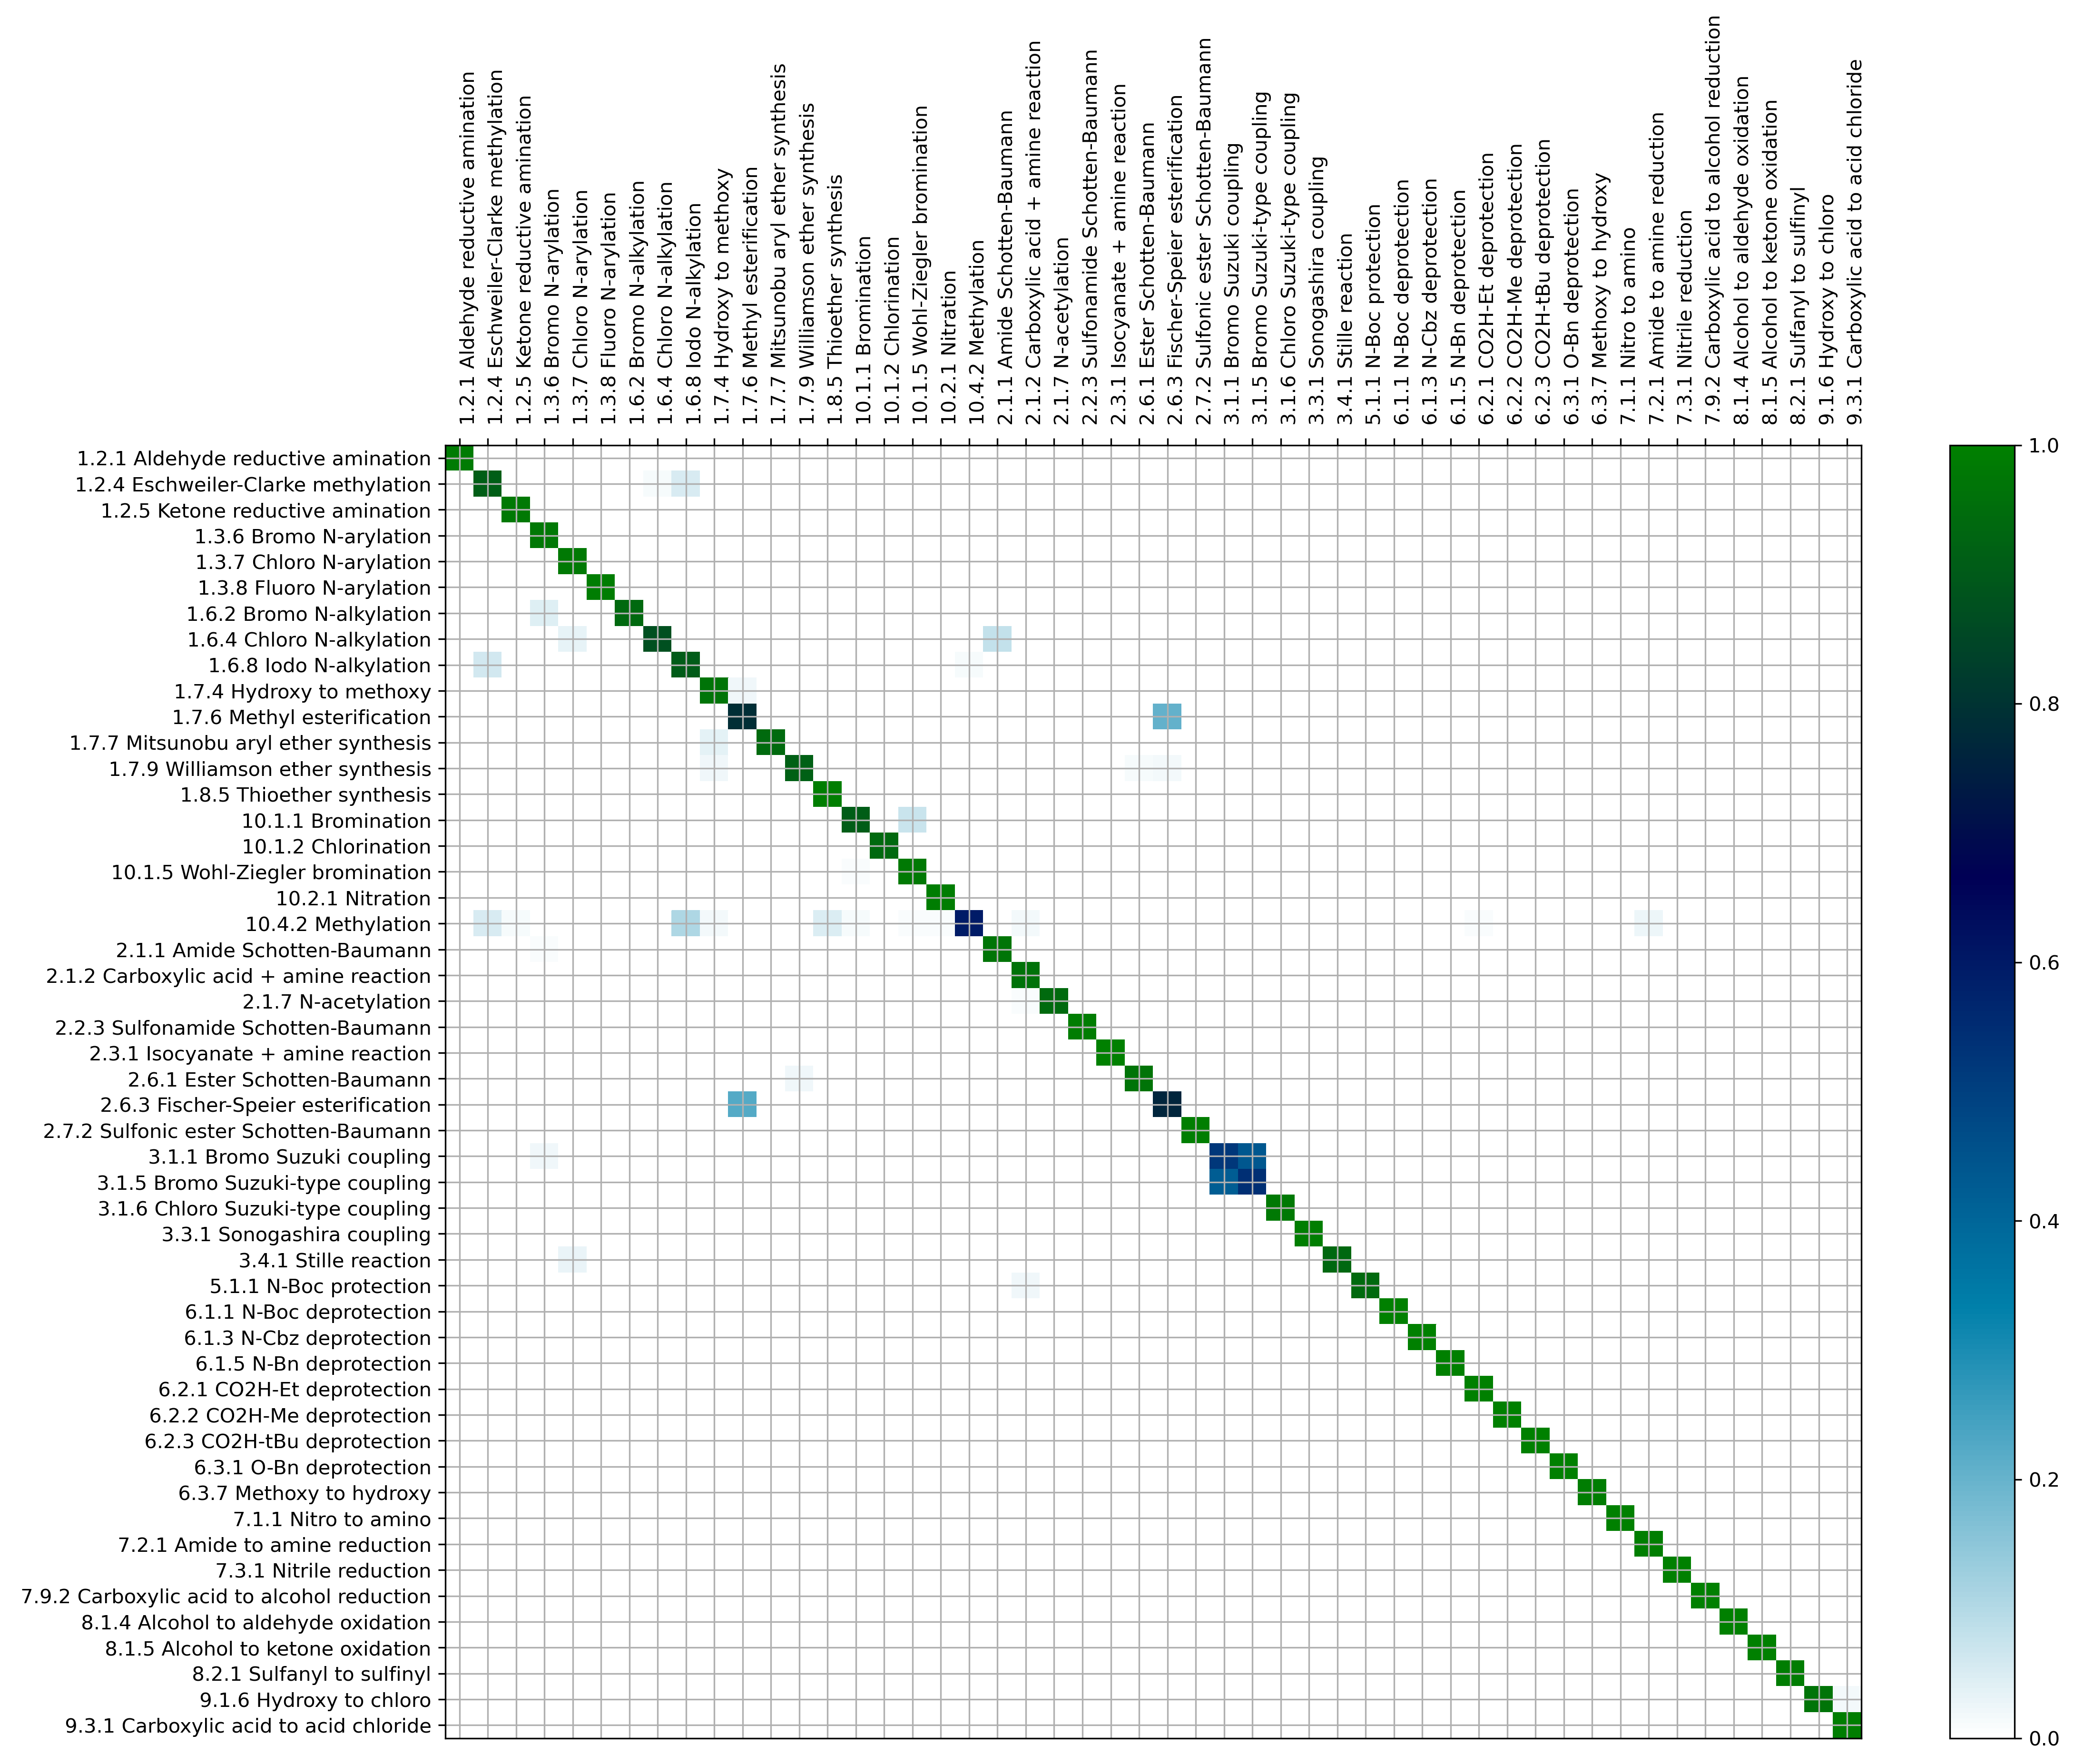

In [35]:
utilsFunctions.labelled_cmat(cmat_fp_MG2,rtypes,figsize=(16,12), labelExtras=names_rTypes)

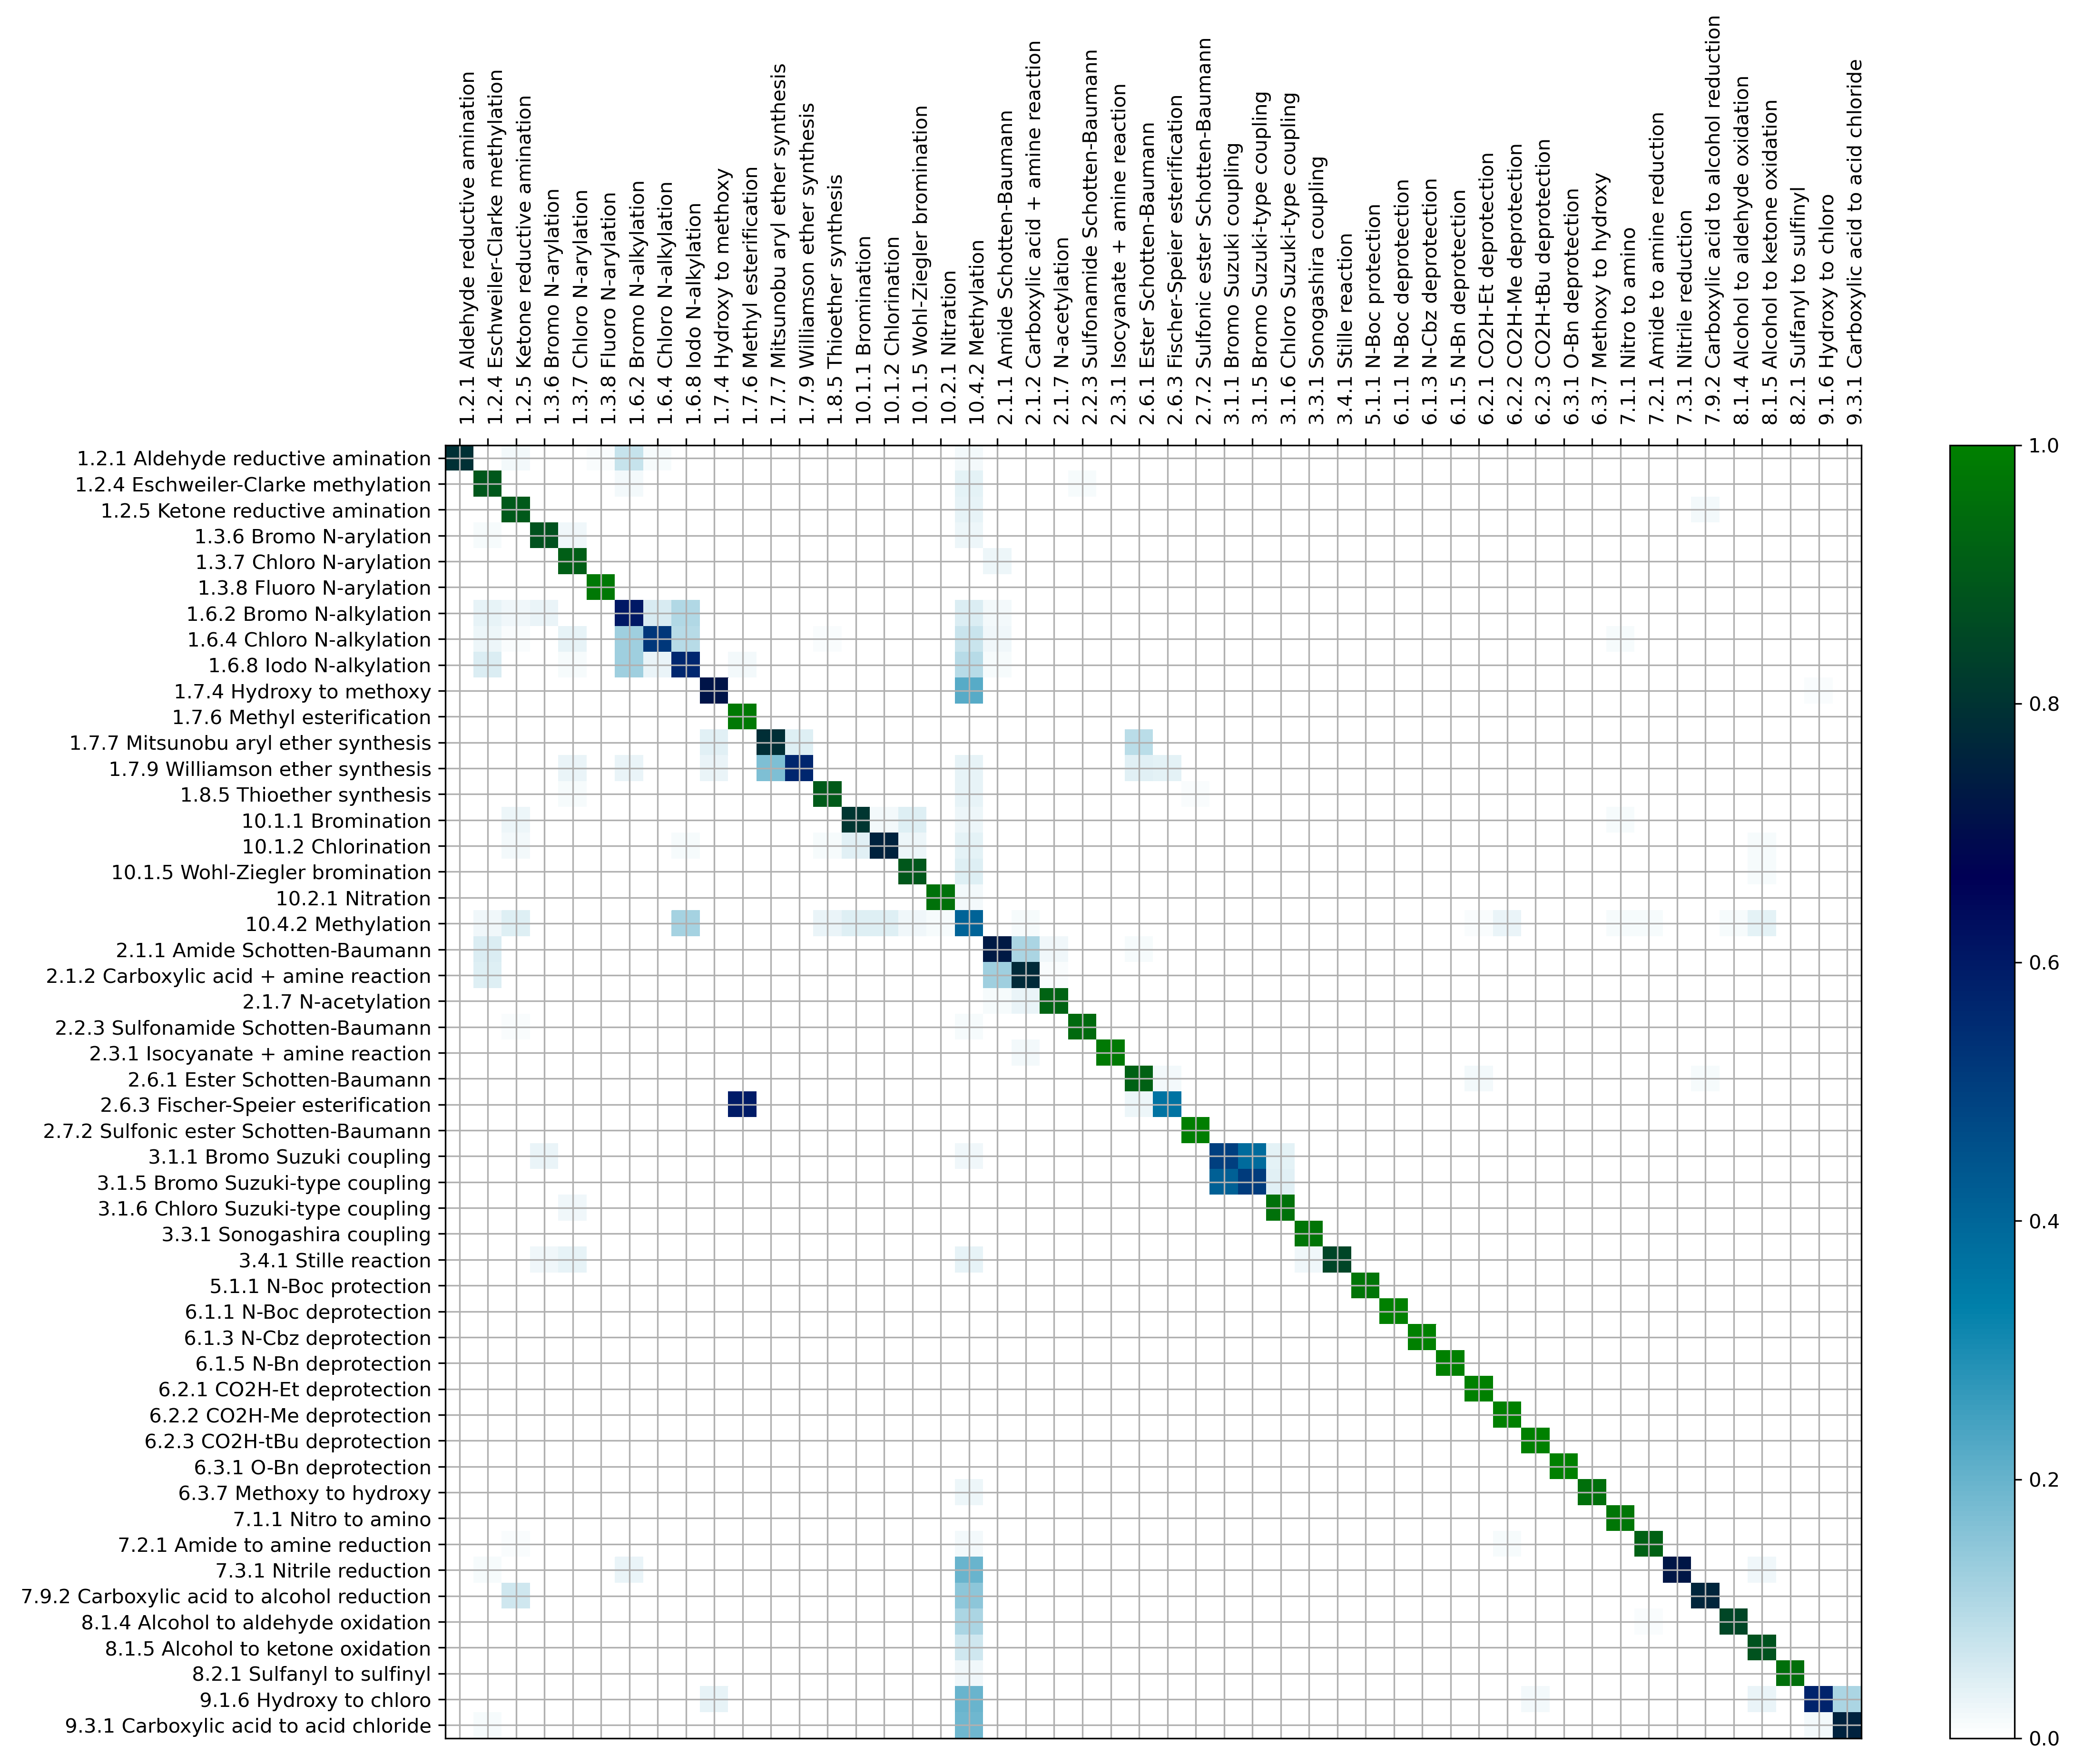

In [36]:
utilsFunctions.labelled_cmat(cmat_fp_TT,rtypes,figsize=(16,12), labelExtras=names_rTypes)